Generate a csv file to use for an AI model for color selection

In [18]:
import random
import csv

def generate_random_color(min_val, max_val):
    return "#{:02x}{:02x}{:02x}".format(
        random.randint(min_val[0], max_val[0]),
        random.randint(min_val[1], max_val[1]),
        random.randint(min_val[2], max_val[2])
    )

def create_dataset(num_samples_per_category):
    # Dictionary with color ranges to be used for classification
    categories = {
        'Black': [(0, 0, 0), (50, 50, 50)],
        'White': [(200, 200, 200), (255, 255, 255)],
        'Dark-Gray': [(50, 50, 50), (100, 100, 100)],
        'Gray': [(100, 100, 100), (150, 150, 150)],
        'Light-Gray': [(150, 150, 150), (200, 200, 200)],
        'Dark-Blue': [(0, 0, 100), (0, 0, 139)],
        'Blue': [(0, 0, 200), (0, 0, 255)],
        'Light-Blue': [(173, 216, 230), (191, 239, 255)],
        'Dark-Brown': [(60, 30, 10), (90, 45, 15)],
        'Brown': [(139, 69, 19), (160, 82, 45)],
        'Cream': [(245, 245, 220), (255, 253, 208)],
        'Dark-Red': [(139, 0, 0), (165, 42, 42)],
        'Red': [(255, 0, 0), (255, 99, 71)],
        'Light-Red': [(255, 160, 122), (255, 182, 193)],
        'Pink': [(255, 182, 193), (255, 192, 203)],
        'Purple': [(128, 0, 128), (160, 32, 240)],
        'Dark-Green': [(0, 100, 0), (0, 128, 0)],
        'Green': [(0, 128, 0), (34, 139, 34)],
        'Light-Green': [(144, 238, 144), (152, 251, 152)],
        'Yellow': [(255, 255, 0), (255, 255, 102)],
        'Orange': [(255, 140, 0), (255, 165, 0)],
        'Peach': [(255, 218, 185), (255, 229, 180)],
        'Gold': [(255, 215, 0), (255, 223, 102)],
    }

    with open('color_dataset.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Hex Color', 'Category'])
        
        for category, (min_val, max_val) in categories.items():
            # Ensure the RGB values for each color range are valid
            min_val = [min(min_val[i], max_val[i]) for i in range(3)]
            max_val = [max(min_val[i], max_val[i]) for i in range(3)]
            
            for _ in range(num_samples_per_category):
                hex_color = generate_random_color(min_val, max_val)
                writer.writerow([hex_color, category])

#generate teh dataset, total number is (classes * number in create_dataset)
create_dataset(200)


Read the CSV file and convert the Hex colors to RGB that way we can get a testing and training split for an AI model

In [19]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
data = pd.read_csv('color_dataset.csv')

# Convert Hex Color to RGB
def hex_to_rgb(hex_color):
    """Convert a hex color to an RGB tuple."""
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

# Apply the RGB conversion to the entire dataset
data['RGB'] = data['Hex Color'].apply(hex_to_rgb)

# Separate features (RGB values) and labels (color category)
X = data['RGB'].apply(pd.Series)  # Split RGB into separate columns
y = data['Category']

# Label encode the color categories
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to torch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


Define our Neural Network architecture and set up the hyperparameters to set up the model

In [20]:
import torch.nn as nn
import torch.optim as optim

class ColorClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        #takes the input size and the output hidden size features
        super(ColorClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        #take the input tensor and apply ReLU activation
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

# Hyperparameters
input_size = 3  # RGB has 3 input features
hidden_size = 128
num_classes = len(label_encoder.classes_)
learning_rate = 0.001

# Initialize model, loss function, and optimizer
model = ColorClassifier(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Run the AI model

In [27]:
# Training the model
num_epochs = 10000
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/10000], Loss: 0.1169
Epoch [20/10000], Loss: 0.1155
Epoch [30/10000], Loss: 0.1141
Epoch [40/10000], Loss: 0.1128
Epoch [50/10000], Loss: 0.1116
Epoch [60/10000], Loss: 0.1104
Epoch [70/10000], Loss: 0.1092
Epoch [80/10000], Loss: 0.1080
Epoch [90/10000], Loss: 0.1069
Epoch [100/10000], Loss: 0.1057
Epoch [110/10000], Loss: 0.1046
Epoch [120/10000], Loss: 0.1035
Epoch [130/10000], Loss: 0.1024
Epoch [140/10000], Loss: 0.1012
Epoch [150/10000], Loss: 0.1002
Epoch [160/10000], Loss: 0.0991
Epoch [170/10000], Loss: 0.0980
Epoch [180/10000], Loss: 0.0970
Epoch [190/10000], Loss: 0.0959
Epoch [200/10000], Loss: 0.0949
Epoch [210/10000], Loss: 0.0938
Epoch [220/10000], Loss: 0.0928
Epoch [230/10000], Loss: 0.0918
Epoch [240/10000], Loss: 0.0908
Epoch [250/10000], Loss: 0.0898
Epoch [260/10000], Loss: 0.0888
Epoch [270/10000], Loss: 0.0878
Epoch [280/10000], Loss: 0.0868
Epoch [290/10000], Loss: 0.0859
Epoch [300/10000], Loss: 0.0849
Epoch [310/10000], Loss: 0.0840
Epoch [320/10000]

Check the model accuracy

In [28]:
# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)

print(f'Model Accuracy: {accuracy * 100:.2f}%')


Model Accuracy: 99.78%


Save the model to be used

In [29]:
# Save the trained model
torch.save(model.state_dict(), 'color_classifier.pth')

# Load the model for future use
model = ColorClassifier(input_size, hidden_size, num_classes)
model.load_state_dict(torch.load('color_classifier.pth'))
model.eval()  # Set the model to evaluation mode


ColorClassifier(
  (fc1): Linear(in_features=3, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=23, bias=True)
  (relu): ReLU()
)

Create a simple predicitive model

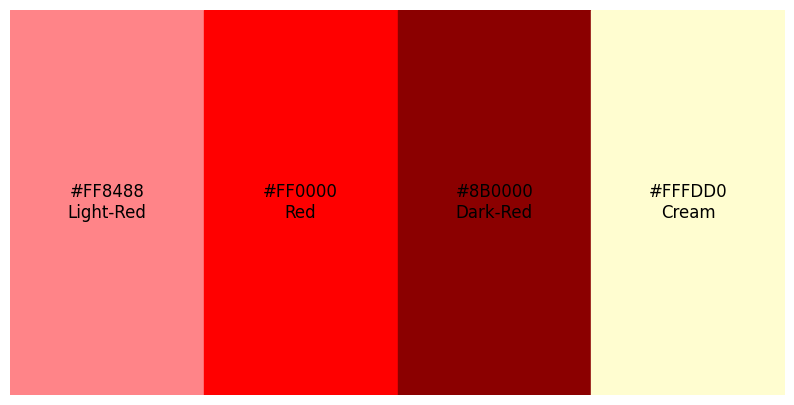

In [42]:
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def hex_to_rgb(hex_color):
    """Convert a hex color to an RGB tuple."""
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

# Define test colors (you can add more as needed)
test_colors = ['#FF8488', '#FF0000', '#8B0000', '#FFFDD0']  
test_rgb = [hex_to_rgb(color) for color in test_colors]

# Convert to torch tensor
test_rgb_tensor = torch.tensor(test_rgb, dtype=torch.float32)

# Predict the categories for the test colors
with torch.no_grad():
    outputs = model(test_rgb_tensor)
    _, predicted = torch.max(outputs, 1)

# Define the label encoder (you should load this if you saved it)
label_encoder = LabelEncoder()
label_encoder.fit([
    'Black', 'White', 'Dark-Gray', 'Gray', 'Light-Gray', 'Dark-Blue', 'Blue', 'Light-Blue',
    'Dark-Brown', 'Brown', 'Cream', 'Dark-Red', 'Red', 'Light-Red', 'Pink', 'Purple',
    'Dark-Green', 'Green', 'Light-Green', 'Yellow', 'Orange', 'Peach', 'Gold'
])  # Ensure this list matches your dataset's categories

# Map the predicted labels to category names
predicted_categories = label_encoder.inverse_transform(predicted.numpy())

# Plotting the results using matplotlib
fig, ax = plt.subplots(figsize=(10, 5))

# Create a color bar
for i, (color, category) in enumerate(zip(test_colors, predicted_categories)):
    # Plot a rectangle with the test color
    ax.add_patch(plt.Rectangle((i*2, 0), 2, 1, color=color))
    ax.text(i*2 + 1, 0.5, f'{color}\n{category}', color='black', ha='center', va='center', fontsize=12)

# Adjust plot limits and remove axes
ax.set_xlim(0, len(test_colors) * 2)
ax.set_ylim(0, 1)
ax.axis('off')

plt.show()
